In [24]:
# imports, helper functions and globals
from pathlib import Path
from typing import List, Tuple, Optional

# import albumentations as A
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
from torchvision.ops import nms
from torchvision import transforms
from tqdm.notebook import tqdm, trange

from torchvision.models.densenet import densenet121
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


2024-12-20 12:03:39.061653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 12:03:39.061775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 12:03:39.201543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
def ls(path: Path):
    return list(path.iterdir())

ROOT = Path("/kaggle/input/amia-public-challenge-2024")

In [26]:
CLASS_IDS_NAMES = {
    0: 'Aortic enlargement',
    1: 'Atelectasis',
    2: 'Calcification',
    3: 'Cardiomegaly',
    4: 'Consolidation',
    5: 'ILD',
    6: 'Infiltration',
    7: 'Lung Opacity',
    8: 'Nodule/Mass',
    9: 'Other lesion',
    10: 'Pleural effusion',
    11: 'Pleural thickening',
    12: 'Pneumothorax',
    13: 'Pulmonary fibrosis',
    14: 'No finding'
}

In [27]:
ls(ROOT)

[PosixPath('/kaggle/input/amia-public-challenge-2024/sample_submission.csv'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/img_size.csv'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/train.csv'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/test.csv'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/test'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/train')]

In [28]:
# List of train image paths
images = ls(ROOT / "train/train")
images[:2]

[PosixPath('/kaggle/input/amia-public-challenge-2024/train/train/8RftDaYYRcnwhIAfSBzMt8qFQw04pJ4U.png'),
 PosixPath('/kaggle/input/amia-public-challenge-2024/train/train/vi6QVLeiI8G1lVTOl0ATLUmqEMeO4UAv.png')]

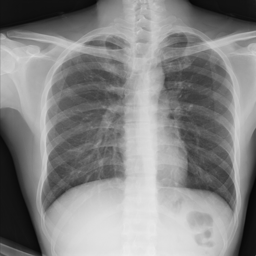

In [29]:
# Reading a single image
Image.open(images[0]).resize((256, 256))

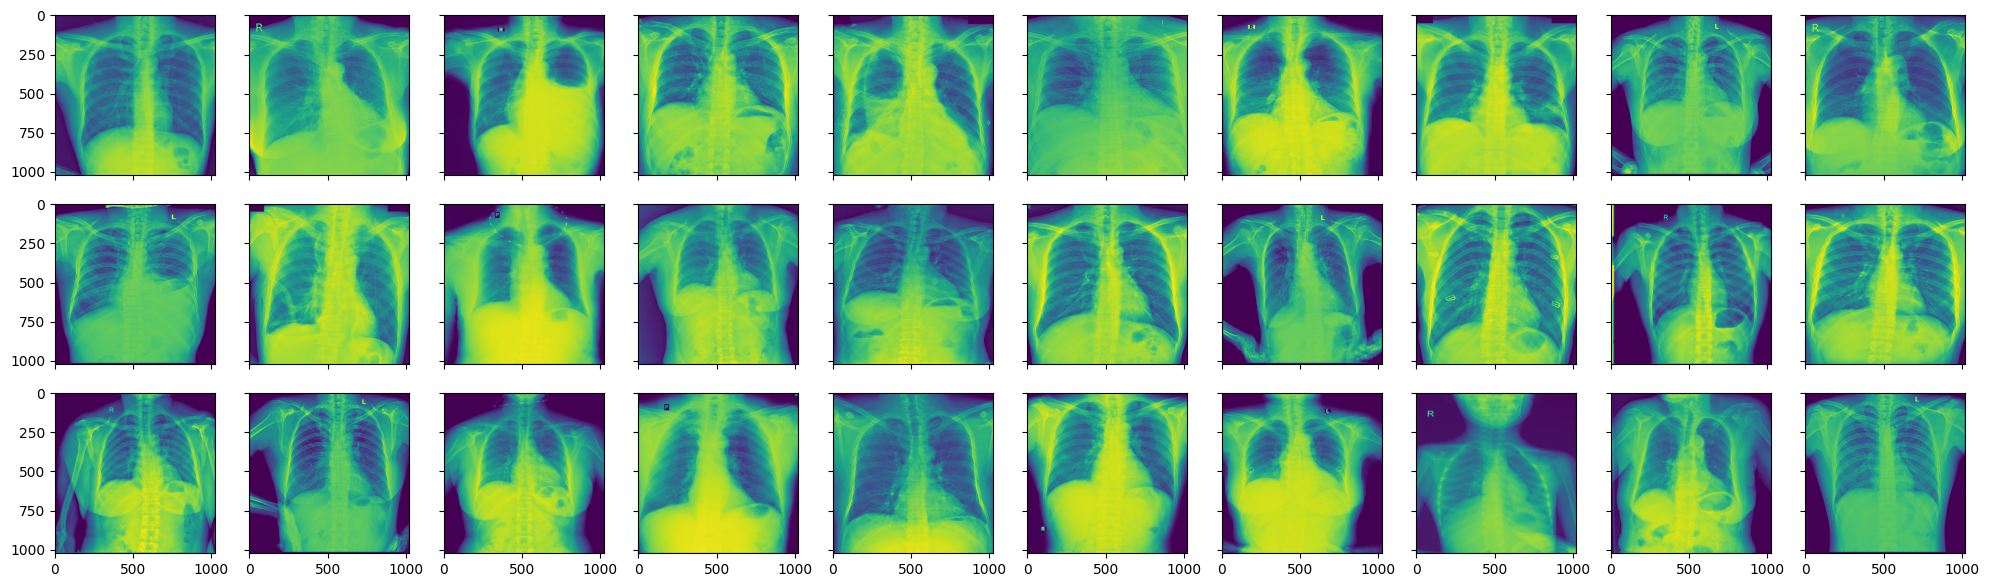

In [30]:
# Some more examples

nrows=3
ncols=10

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True)
fig.set_size_inches(ncols * 2, nrows * 2)
i = 0
for row in range(nrows):
    for col in range(ncols):
        image = np.array(Image.open(images[i]))
        axs[row, col].imshow(image)
        i += 1

plt.tight_layout()
plt.show()

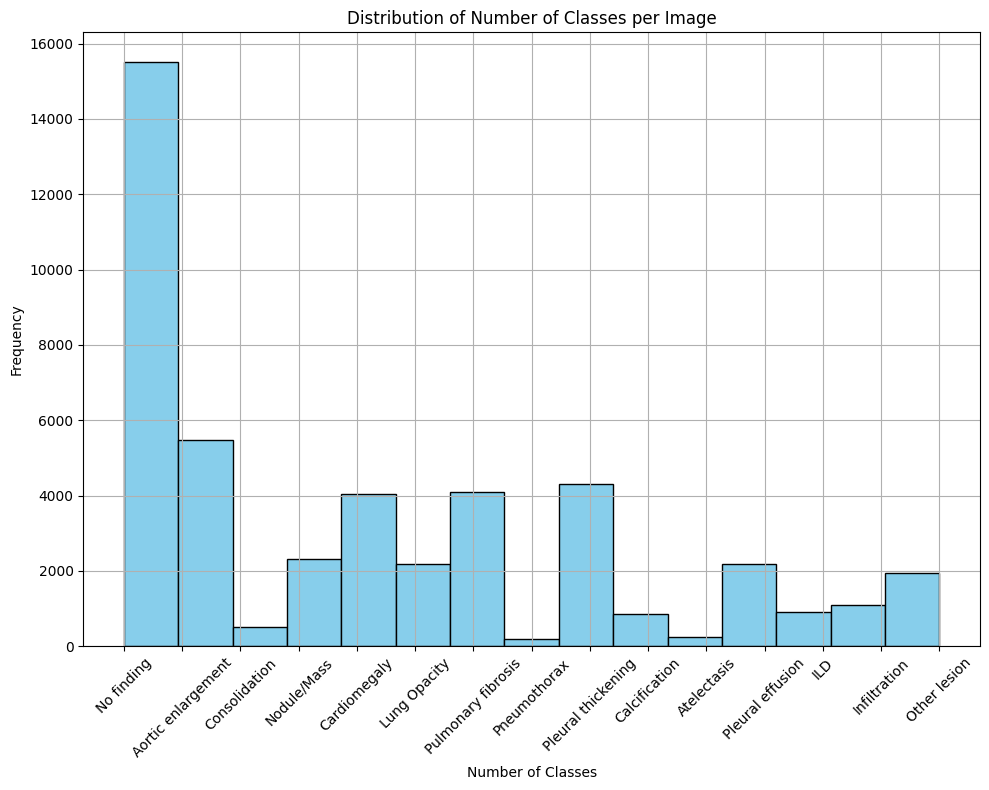

In [31]:
data = pd.read_csv("/kaggle/input/amia-public-challenge-2024/train.csv")# Plot histogram
plt.figure(figsize=(10,8 ))
plt.hist(data['class_name'], bins=15, color='skyblue', edgecolor='black')

# Enhance x-axis readability
plt.title('Distribution of Number of Classes per Image')
plt.xlabel('Number of Classes')
plt.ylabel('Frequency')
plt.grid(True)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)  # Rotate labels

# Use tight_layout to avoid overlap
plt.tight_layout()

# Show plot
plt.show()

In [32]:
# Mapping of class ids to class names
data.groupby("class_id").class_name.first().to_dict()

{0: 'Aortic enlargement',
 1: 'Atelectasis',
 2: 'Calcification',
 3: 'Cardiomegaly',
 4: 'Consolidation',
 5: 'ILD',
 6: 'Infiltration',
 7: 'Lung Opacity',
 8: 'Nodule/Mass',
 9: 'Other lesion',
 10: 'Pleural effusion',
 11: 'Pleural thickening',
 12: 'Pneumothorax',
 13: 'Pulmonary fibrosis',
 14: 'No finding'}

## 1. Precompute dataset mean and std.dev

In [33]:
def compute_mean_std(image_paths):
    total_sum = 0
    total_pixels = 0
    total_sum_squared = 0
    
    # Iterate over all images in the folder
    for image_path in image_paths:  # Adjust the extension if needed
        image = Image.open(image_path)
        image_np = np.array(image) / 255.0  # Normalize to [0, 1]
        
        # Accumulate the sum of all pixel values
        total_sum += np.sum(image_np)
        total_sum_squared += np.sum(image_np **2)
        
        # Accumulate the total number of pixels
        total_pixels += image_np.size
    
    # Compute the mean across all images
    mean = total_sum / total_pixels
    mean_squared = total_sum_squared / total_pixels
    variance = (mean_squared - mean **2)
    std_dev = np.sqrt(variance)
    
    return mean, std_dev


In [34]:
mean, std_dev = compute_mean_std(ls(ROOT / "train/train"))
print(mean, std_dev)

0.5471050584672299 0.2684161637775519


In [35]:
print(mean, std_dev)

0.5471050584672299 0.2684161637775519


## 2. Dataset class

In [36]:
def to_one_hot_encoded(class_indeces, num_classes=15) -> torch.Tensor:
    one_hot_encoded = torch.zeros(num_classes)
    one_hot_encoded[torch.unique(torch.tensor(class_indeces))] = 1.
    return one_hot_encoded

In [37]:
def create_one_hot_encoding(class_ids, num_classes=15):
    encoding = np.zeros(num_classes, dtype=int)  # Create an array of zeros with 15 elements
    for class_id in class_ids:
        encoding[class_id] = 1  # Set the value at the index corresponding to the class_id to 1
    return encoding

In [38]:
class AMIADataset():
    def __init__(self, root, partition: str, transform=None, indices: Optional[list] = None):
        self.num_classes = 15
        
        self.root = Path(root)
        
        self.data = pd.read_csv(ROOT / f"{partition}.csv")
        self.images = ls(ROOT/ f"{partition}/{partition}")
        
        if indices is not None:
            self.images = [self.images[i] for i in indices]
        
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        
        #sample by img_id
        image_path = self.images[idx]
        image = np.array(Image.open(image_path))
        # Convert image to float tensor
        image = np.array(image).astype(np.float32) / 255.0  # Normalize to [0, 1]
        image = torch.unsqueeze(torch.tensor(image), 0) #add channel dimension
        
        if self.transform:
            image = self.transform(image)
        
        #filter annotation for patient
        image_id = image_path.stem
        sample = self.data[self.data.image_id == image_id]
        
        #generate one hot encode target vector
        labels = to_one_hot_encoded(sample.class_id.unique())
        
        return image, labels

In [39]:
train_dataset = AMIADataset("/kaggle/input/amia-public-challenge-2024", 'train')
image, label = train_dataset[1]
print(image.shape)
print(label)

#del train_dataset

torch.Size([1, 1024, 1024])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.])


In [40]:
train_dataset.__len__()

8573

In [41]:
train_dataset.data

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,bM8C97htulC9fHKIDurJHquCXr1KZuug,No finding,14,R5,NaN,NaN,NaN,NaN
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R10,1148.0,503.0,1466.0,823.0
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w,Consolidation,4,R8,264.0,732.0,550.0,1119.0
3,vqw6mWifHgCf8jmTotrMAS3qCk5eJuc4,No finding,14,R13,NaN,NaN,NaN,NaN
4,EzfCkMwi4E5bAtZZo4brqt9dNbm7sF9z,No finding,14,R5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
45920,2nu3UdPqvAVfRRuLcdpWS7XNieBBlgSF,Pleural effusion,10,R9,491.0,549.0,1544.0,2725.0
45921,wQtrKg6nlN2wadrVTWXn5WYe1TsB38pB,Pulmonary fibrosis,13,R8,841.0,1130.0,1213.0,1295.0
45922,WFG7bP8fltyd7Awrm3YXoYUO5X6UEzbb,Pleural effusion,10,R9,30.0,1293.0,866.0,1801.0
45923,cwVcnee8qkxNdKnOEsKFHuduCWmqffXb,Aortic enlargement,0,R8,1597.0,838.0,1852.0,1189.0


## Data Augmentations

In [42]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),  # Resize images to 224x224 for DenseNet
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize([mean], [std_dev])  # Normalize using ImageNet means and std
])

In [43]:
# Create the full dataset
full_dataset = AMIADataset("/kaggle/input/amia-public-challenge-2024", 'train')

# Split indices
num_samples = len(full_dataset)
indices = list(range(num_samples))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)  # 20% validation

# Create training and validation datasets
train_dataset = AMIADataset("/kaggle/input/amia-public-challenge-2024", 'train',transform=transform, indices=train_indices)
val_dataset = AMIADataset("/kaggle/input/amia-public-challenge-2024", 'train', transform=transform, indices=val_indices)

In [44]:
print(len(val_dataset))

1715


In [45]:
BATCH_SIZE = 32

In [46]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [47]:
# Load a pre-trained DenseNet model
densenet = densenet121(weights=None)

# Modify the first convolutional layer to accept single channel input
densenet.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final layer to output 15 classes
num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, 15)  # 15 classes for multi-label classification

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet = densenet.to(device)

In [48]:
# Training parameters
epochs = 15
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=1e-5)

# Initialize lists to store loss values
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    densenet.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = densenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 9:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    print("-"*20)
    print(f"Epoch [{epoch+1}/{epochs}] completed. Average Loss: {epoch_loss:.4f}")
    
    
    # Validation phase
    densenet.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculations for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = densenet(images)
            val_loss += criterion(outputs, labels).item()

            # Calculate accuracy
            predicted = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold at 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.numel()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print("-"*20 + "\n")
    

Epoch [1/15], Batch [10/215], Loss: 0.6698
Epoch [1/15], Batch [20/215], Loss: 0.6470
Epoch [1/15], Batch [30/215], Loss: 0.6323
Epoch [1/15], Batch [40/215], Loss: 0.6195
Epoch [1/15], Batch [50/215], Loss: 0.6035
Epoch [1/15], Batch [60/215], Loss: 0.5832
Epoch [1/15], Batch [70/215], Loss: 0.5884
Epoch [1/15], Batch [80/215], Loss: 0.5570
Epoch [1/15], Batch [90/215], Loss: 0.5569
Epoch [1/15], Batch [100/215], Loss: 0.5608
Epoch [1/15], Batch [110/215], Loss: 0.5406
Epoch [1/15], Batch [120/215], Loss: 0.5358
Epoch [1/15], Batch [130/215], Loss: 0.5083
Epoch [1/15], Batch [140/215], Loss: 0.5073
Epoch [1/15], Batch [150/215], Loss: 0.4977
Epoch [1/15], Batch [160/215], Loss: 0.5220
Epoch [1/15], Batch [170/215], Loss: 0.4865
Epoch [1/15], Batch [180/215], Loss: 0.4571
Epoch [1/15], Batch [190/215], Loss: 0.4389
Epoch [1/15], Batch [200/215], Loss: 0.4610
Epoch [1/15], Batch [210/215], Loss: 0.4556
--------------------
Epoch [1/15] completed. Average Loss: 0.5470
Validation Loss: 0.

In [49]:
model_path = "densenet_model.pth"
torch.save(densenet.state_dict(), model_path)

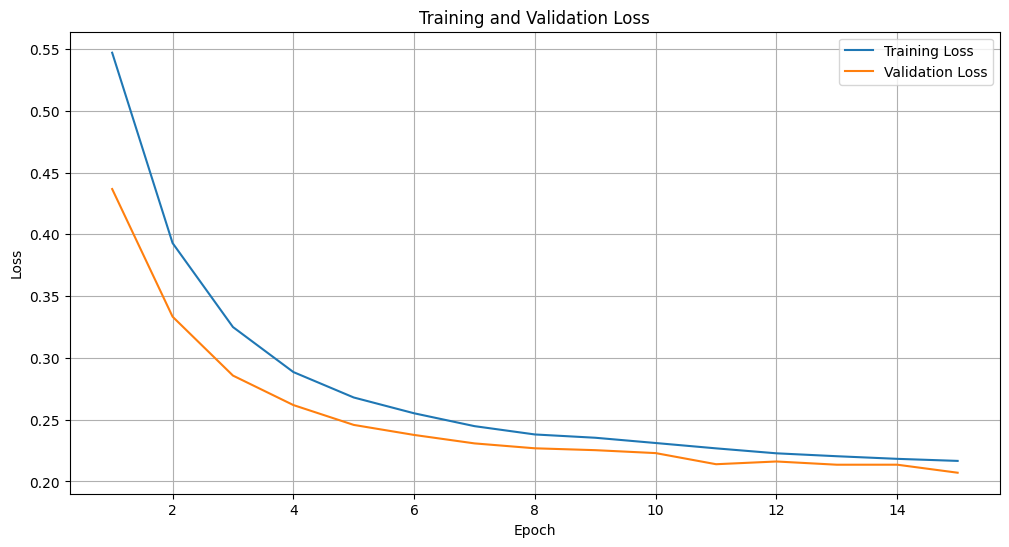

In [50]:
# Plot Loss Curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

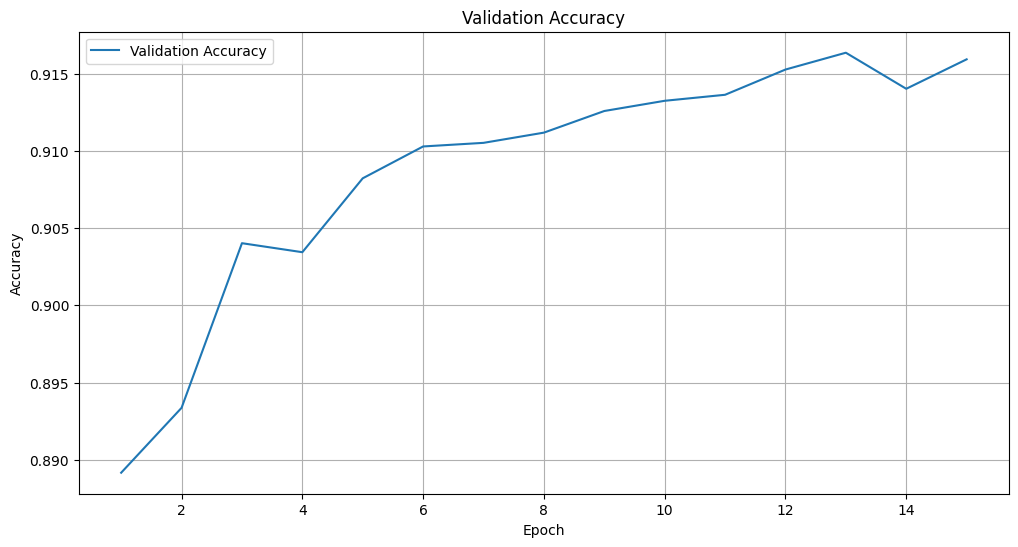

In [51]:
# Plot Accuracy Curves
plt.figure(figsize=(12, 6))
#plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix:
[[411   0   0   1   0   0   0   0   0   0   0   3   0   0  42]
 [ 19   0   0   0   0   0   0   0   0   0   0   0   0   0   3]
 [ 18   0   0   0   0   0   0   0   0   0   0   0   0   0   6]
 [ 25   0   0   1   0   0   0   0   0   0   0   0   0   0   6]
 [ 17   0   0   0   0   0   0   0   0   0   0   0   0   0   6]
 [ 14   0   0   0   0   0   0   0   0   0   0   1   0   0   4]
 [  8   0   0   0   0   0   0   0   0   0   0   1   0   0   5]
 [ 17   0   0   0   0   0   0   0   0   0   0   1   0   0   4]
 [  9   0   0   0   0   0   0   0   0   0   0   1   0   0   5]
 [  3   0   0   0   0   0   0   0   0   0   0   0   0   0   3]
 [  3   0   0   0   0   0   0   0   0   0   0   0   0   0   4]
 [  8   0   0   0   0   0   0   0   0   0   0   1   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0   0   0   0   0   2]
 [ 67   0   0   0   0   0   0   0   0   0   0   1   0   0 989]]


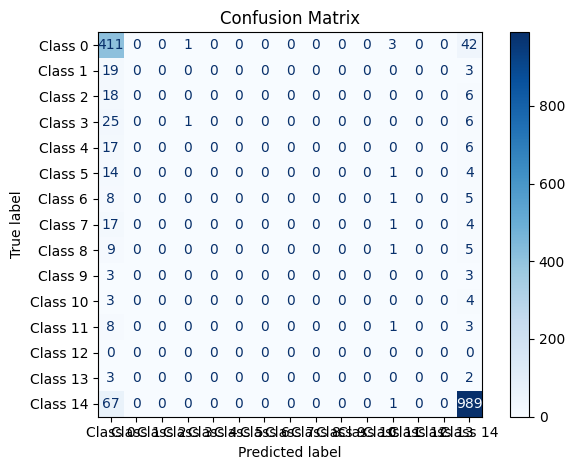

In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect all true labels and predictions
all_labels = []
all_preds = []

densenet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = densenet(images)
        predicted = torch.sigmoid(outputs).cpu().numpy() > 0.5  # Apply sigmoid and threshold
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted)

# Convert lists to numpy arrays and flatten
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Convert to class indices
all_preds_classes = np.argmax(all_preds, axis=1)
all_labels_classes = np.argmax(all_labels, axis=1)

# Compute confusion matrix
num_classes = 15  # Number of classes in your dataset
cm = confusion_matrix(all_labels_classes, all_preds_classes, labels=range(num_classes))

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Class {i}' for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


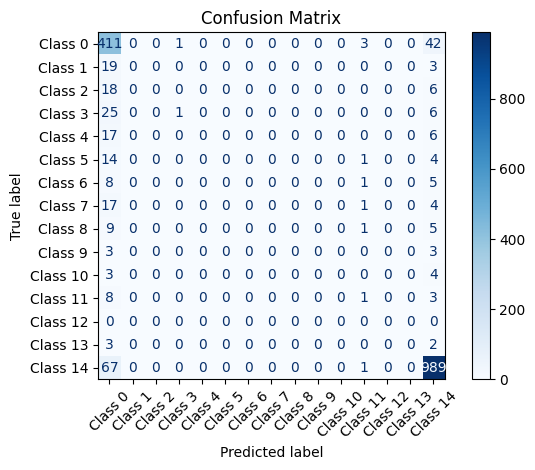

In [53]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Class {i}' for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

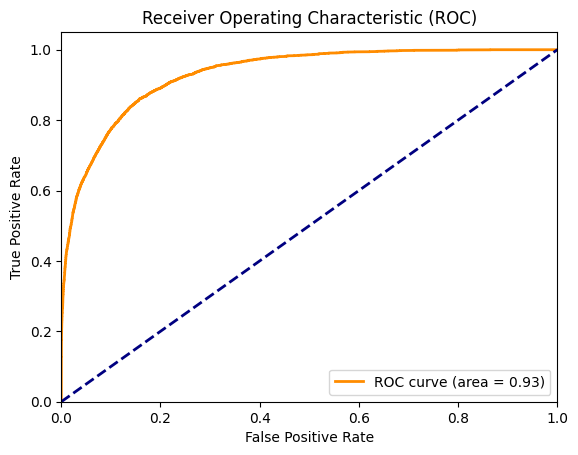

In [54]:
from sklearn.metrics import roc_curve, auc

# Assuming you have all true labels and predicted scores
all_labels = []
all_scores = []

densenet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = densenet(images)
        scores = torch.sigmoid(outputs).cpu().numpy()

        all_labels.extend(labels.cpu().numpy())
        all_scores.extend(scores)

# Flatten the lists
all_labels = np.array(all_labels).flatten()
all_scores = np.array(all_scores).flatten()

# Compute ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [55]:
densenet.eval()  # Set the model to evaluation mode
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in train_loader:  # In practice, use a separate validation loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = densenet(images)
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(torch.sigmoid(outputs).cpu().numpy())  # Apply sigmoid to get probabilities

# Calculate AUC for each class
all_labels = np.concatenate(all_labels)
all_outputs = np.concatenate(all_outputs)

for i in range(15):
    auc = roc_auc_score(all_labels[:, i], all_outputs[:, i])
    print(f"AUC for class {i}: {auc}")

AUC for class 0: 0.9382894987611968
AUC for class 1: 0.8389784421142356
AUC for class 2: 0.8302698886888198
AUC for class 3: 0.9345250666081296
AUC for class 4: 0.8593573472844545
AUC for class 5: 0.8382397599185438
AUC for class 6: 0.8452044125805487
AUC for class 7: 0.866864400632222
AUC for class 8: 0.8565697489672705
AUC for class 9: 0.852892743005432
AUC for class 10: 0.8758979178844076
AUC for class 11: 0.8949544576647827
AUC for class 12: 0.8319613984366634
AUC for class 13: 0.8728678023916118
AUC for class 14: 0.9793600642364125


In [56]:

optimal_thresholds = []

for i in range(15):
    fpr, tpr, thresholds = roc_curve(all_labels[:, i], all_outputs[:, i])
    youden_index = tpr - fpr
    optimal_threshold = thresholds[np.argmax(youden_index)]
    optimal_thresholds.append(optimal_threshold)
    print(f"Optimal threshold for class {i}: {optimal_threshold:.4f}")

Optimal threshold for class 0: 0.2005
Optimal threshold for class 1: 0.0307
Optimal threshold for class 2: 0.0453
Optimal threshold for class 3: 0.2736
Optimal threshold for class 4: 0.0564
Optimal threshold for class 5: 0.0471
Optimal threshold for class 6: 0.0569
Optimal threshold for class 7: 0.1163
Optimal threshold for class 8: 0.0869
Optimal threshold for class 9: 0.1086
Optimal threshold for class 10: 0.0890
Optimal threshold for class 11: 0.1451
Optimal threshold for class 12: 0.0127
Optimal threshold for class 13: 0.1391
Optimal threshold for class 14: 0.5822


In [57]:
from sklearn.metrics import f1_score

optimal_thresholds = []

for i in range(15):
    f1_scores = []
    thresholds = np.arange(0.0, 1.0, 0.01)
    for threshold in thresholds:
        y_pred = (all_outputs[:, i] >= threshold).astype(int)
        f1 = f1_score(all_labels[:, i], y_pred)
        f1_scores.append(f1)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    optimal_thresholds.append(optimal_threshold)
    print(f"Optimal threshold for class {i}: {optimal_threshold:.4f}")

Optimal threshold for class 0: 0.4000
Optimal threshold for class 1: 0.0500
Optimal threshold for class 2: 0.0900
Optimal threshold for class 3: 0.3600
Optimal threshold for class 4: 0.1200
Optimal threshold for class 5: 0.1100
Optimal threshold for class 6: 0.1600
Optimal threshold for class 7: 0.2600
Optimal threshold for class 8: 0.1700
Optimal threshold for class 9: 0.2000
Optimal threshold for class 10: 0.2700
Optimal threshold for class 11: 0.2400
Optimal threshold for class 12: 0.0300
Optimal threshold for class 13: 0.2500
Optimal threshold for class 14: 0.5500


In [58]:
y_pred_binary = np.zeros_like(all_outputs)

for i in range(15):
    y_pred_binary[:, i] = (all_outputs[:, i] >= optimal_thresholds[i]).astype(int)

# Now calculate accuracy or any other metric
for i in range(15):
    accuracy = accuracy_score(all_labels[:, i], y_pred_binary[:, i])
    print(f"Accuracy for class {i} with optimal threshold: {accuracy:.4f}")

Accuracy for class 0 with optimal threshold: 0.8734
Accuracy for class 1 with optimal threshold: 0.9364
Accuracy for class 2 with optimal threshold: 0.8260
Accuracy for class 3 with optimal threshold: 0.8749
Accuracy for class 4 with optimal threshold: 0.9318
Accuracy for class 5 with optimal threshold: 0.9267
Accuracy for class 6 with optimal threshold: 0.8784
Accuracy for class 7 with optimal threshold: 0.8045
Accuracy for class 8 with optimal threshold: 0.8163
Accuracy for class 9 with optimal threshold: 0.7797
Accuracy for class 10 with optimal threshold: 0.8548
Accuracy for class 11 with optimal threshold: 0.7948
Accuracy for class 12 with optimal threshold: 0.8574
Accuracy for class 13 with optimal threshold: 0.7919
Accuracy for class 14 with optimal threshold: 0.9315


In [59]:
test_df = pd.read_csv("/kaggle/input/amia-public-challenge-2024/test.csv")

In [60]:
class ThoracicDataset1(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = f"{self.img_dir}/{self.dataframe.iloc[idx, 0]}.png"
        image = Image.open(img_name)
        image = np.array(image).astype(np.float32) / 255.0  # Normalize to [0, 1]
        image = torch.unsqueeze(torch.tensor(image), 0)

        # Test dataset does not have labels
        if self.transform:
            image = self.transform(image)

        return image

# Define the test dataset and dataloader
test_dataset = ThoracicDataset1(dataframe=test_df, img_dir="/kaggle/input/amia-public-challenge-2024/test/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

densenet.eval()  # Set the model to evaluation mode
all_test_outputs = []

with torch.no_grad():
    num_batches = len(test_loader)
    for batch_idx, images in enumerate(test_loader):
        images = images.to(device)

        outputs = densenet(images)
        all_test_outputs.append(torch.sigmoid(outputs).cpu().numpy())  # Apply sigmoid to get probabilities

        # Print progress
        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f"Processing batch {batch_idx + 1}/{num_batches}")

# Convert list to numpy array
all_test_outputs = np.concatenate(all_test_outputs)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(all_test_outputs, columns=[f'class_{i}' for i in range(15)])

# Add image_id column to match the test_df
predictions_df['image_id'] = test_df['image_id']

# Save predictions to CSV
predictions_df.to_csv('submission_predictions.csv', index=False)

# Example of creating a CSV for submission
submission = pd.DataFrame(all_test_outputs, columns=[f'class_{i}' for i in range(15)])
submission['image_id'] = test_df['image_id']
submission = submission[['image_id'] + [f'class_{i}' for i in range(15)]]
submission.to_csv('submission_predictions.csv', index=False)

Processing batch 1/688
Processing batch 11/688
Processing batch 21/688
Processing batch 31/688
Processing batch 41/688
Processing batch 51/688
Processing batch 61/688
Processing batch 71/688
Processing batch 81/688
Processing batch 91/688
Processing batch 101/688
Processing batch 111/688
Processing batch 121/688
Processing batch 131/688
Processing batch 141/688
Processing batch 151/688
Processing batch 161/688
Processing batch 171/688
Processing batch 181/688
Processing batch 191/688
Processing batch 201/688
Processing batch 211/688
Processing batch 221/688
Processing batch 231/688
Processing batch 241/688
Processing batch 251/688
Processing batch 261/688
Processing batch 271/688
Processing batch 281/688
Processing batch 291/688
Processing batch 301/688
Processing batch 311/688
Processing batch 321/688
Processing batch 331/688
Processing batch 341/688
Processing batch 351/688
Processing batch 361/688
Processing batch 371/688
Processing batch 381/688
Processing batch 391/688
Processing 

In [61]:
predictions_df.head()


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10,class_11,class_12,class_13,class_14,image_id
0,0.127404,0.029024,0.042576,0.064318,0.044819,0.045799,0.063822,0.113054,0.087707,0.093684,0.088065,0.165505,0.026788,0.167468,0.673950,3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c
1,0.016677,0.008825,0.011139,0.018575,0.010066,0.009875,0.013157,0.017032,0.012026,0.015555,0.013073,0.015108,0.007189,0.018943,0.975833,LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm
2,0.004209,0.003521,0.003974,0.005422,0.003998,0.003277,0.004722,0.005173,0.004496,0.005020,0.005508,0.004780,0.003094,0.005292,0.994824,PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W
3,0.454358,0.041493,0.090104,0.319821,0.072246,0.109631,0.162627,0.243316,0.153672,0.218140,0.174517,0.378984,0.026441,0.350938,0.178386,l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL
4,0.097312,0.013530,0.022455,0.082698,0.015775,0.028380,0.033163,0.042197,0.032136,0.046800,0.043276,0.084758,0.007660,0.068962,0.794221,if5Pqu95xLUtURzAo72YiSg8GNzJb1F3


In [62]:
# Apply the corresponding threshold for each class to convert predictions into one-hot encoding
one_hot_predictions = np.zeros_like(all_test_outputs, dtype=int)

for i in range(15):
    one_hot_predictions[:, i] = (all_test_outputs[:, i] >= optimal_thresholds[i]).astype(int)

# Convert the one-hot encoded predictions to a DataFrame
one_hot_df = pd.DataFrame(one_hot_predictions, columns=[f'class_{i}' for i in range(15)])

# Add the image_id column to match with the original test_df
one_hot_df['image_id'] = predictions_df['image_id']

# Rearrange columns so that 'image_id' is the first column
one_hot_df = one_hot_df[['image_id'] + [f'class_{i}' for i in range(15)]]

# Save the one-hot encoded predictions to a CSV file
one_hot_df.to_csv('one_hot_encoded_predictions.csv', index=False)

# Display the first few rows of the one-hot encoded DataFrame
one_hot_df.head()


,image_id,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10,class_11,class_12,class_13,class_14
0,3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0
4,if5Pqu95xLUtURzAo72YiSg8GNzJb1F3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [63]:
# Save the one-hot encoded predictions to a CSV file
output_path = 'one_hot_encoded_predictions.csv'
one_hot_df.to_csv(output_path, index=False)